In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import nltk
from textblob import TextBlob, Word
plt.style.use("fivethirtyeight")
import pyLDAvis, pyLDAvis.sklearn
from IPython.display import display
import plotly.express as px

import itertools
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report,  confusion_matrix, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB  
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import LatentDirichletAllocation,  TruncatedSVD, NMF

In [224]:
papers = pd.read_excel('Paper_dataCompiled.xlsx')
papers.head()

,Source,Title,Abstract,Journal,Author,Date,Keyword,Keyword2,Keyword3,Keyword4,Keyword5,General,Citation,Field,Search Term
0,https://www.semanticscholar.org/paper/Space-ch...,Space-charge limited photocurrent.,""":""In 1971 Goodman and Rose predicted the occu...",Physical review letters,Valentin D. Mihailetchi and Jurjen Wildeman an...,2005,Fullerenes,Immunostimulating conjugate (antigen),Switch Device Component,Semiconductors,light intensity,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Mihailetchi2005SpacechargeLP, title=...",Physics,Space
1,https://www.semanticscholar.org/paper/Separabl...,Separable dual-space Gaussian pseudopotentials.,""":""We present pseudopotential coefficients for...","Physical review. B, Condensed matter",Goedecker and Teter and Hutter,1996,Dual,Normal Statistical Distribution,Multiplication,NaN,NaN,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Goedecker1996SeparableDG, title={Sep...",Physics,Space
2,https://www.semanticscholar.org/paper/Canonica...,Canonical dynamics: Equilibrium phase-space di...,""":""Nose has modified Newtonian dynamics so as ...","Physical review. A, General physics",Hoover,1985,Normal Statistical Distribution,Friction,CNS disorder,Test scaling,NaN,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Hoover1985CanonicalDE, title={Canoni...",Physics,Space
3,https://www.semanticscholar.org/paper/Flat-spa...,Flat-space chiral gravity.,""":""We provide the first evidence for a hologra...",Physical review letters,Arjun Bagchi and St{\'e}phane Detournay and Da...,2012,Holographic principle,Quantum field theory,Calcifying Fibrous Pseudotumor,Hornbostelâ€“Sachs,Battery management system,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Bagchi2012FlatspaceCG, title={Flat-s...",Physics,Space
4,https://www.semanticscholar.org/paper/Polariza...,Polarization demultiplexing in Stokes space.,""":""A technique is demonstrated for polarizatio...",Optics express,Bogdan Szafraniec and Bernd Nebendahl and Todd...,2010,chaperone-mediated autophagy,algorithm,Fiber Optic Cables,NaN,NaN,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Szafraniec2010PolarizationDI, title=...",Physics,Space


In [225]:
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 15 columns):
Source         2000 non-null object
Title          1990 non-null object
Abstract       2000 non-null object
Journal        1756 non-null object
Author         2000 non-null object
Date           2000 non-null object
Keyword        1852 non-null object
Keyword2       1626 non-null object
Keyword3       1368 non-null object
Keyword4       1123 non-null object
Keyword5       896 non-null object
General        2000 non-null object
Citation       2000 non-null object
Field          2000 non-null object
Search Term    2000 non-null object
dtypes: object(15)
memory usage: 234.5+ KB


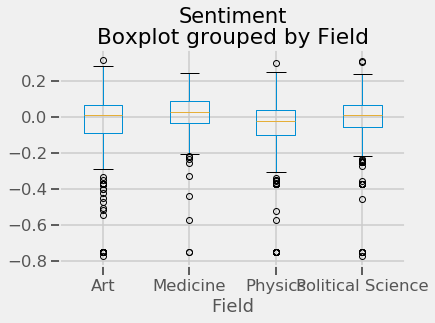

In [226]:
# Sentiment
def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

papers["Sentiment"] = papers["Abstract"].apply(detect_sentiment)

ax= papers.boxplot(column="Sentiment", by="Field")
ax.set_title("Sentiment", fontsize=21, y=1.1);

# Could try by sentence instead of by whole abstract.

In [227]:
papers["Field"].value_counts(normalize=True)

# So null model would be correct 25% of the time

Political Science    0.25
Physics              0.25
Art                  0.25
Medicine             0.25
Name: Field, dtype: float64

# need to vectorize BEFORE train-test split

In [228]:
vect = CountVectorizer(min_df=2, ngram_range=(1,4), stop_words="english")
X = vect.fit_transform(papers["Abstract"])

X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

# one hot encoding of labels
+ useful for some models and plots

In [229]:
y = papers['Field']
m = LabelEncoder()
m.fit(y)
list(m.classes_)

['Art', 'Medicine', 'Physics', 'Political Science']

In [230]:
y_hot_labels = m.transform(y)
y_hot_labels

array([2, 2, 2, ..., 0, 0, 0])

In [231]:
m.inverse_transform(y_hot_labels)

array(['Physics', 'Physics', 'Physics', ..., 'Art', 'Art', 'Art'],
      dtype=object)

In [232]:
#X_train, X_test, y_train, y_test = train_test_split(X_dtm, papers["Field"])

# Need to train test split by category

#Fix split- shuffle
rs = StratifiedShuffleSplit(n_splits=1, random_state=24, test_size=0.25, train_size=None)
for train_index, test_index in rs.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)


X_train = X[train_index,:]
X_test =  X[test_index,:]
y_train = y[train_index]
y_test = y[test_index]
##X_train1 = np.array(X_traina)
#X_test1 = np.array(X_testa)

TRAIN: [1327  438 1424 ... 1412  866 1573] TEST: [ 248  988 1480 1512  363 1640 1699 1538  870  326  389   33  114  135
  580  526 1052   88 1229  426  193  391  122 1874 1190 1084  373 1692
  401  906 1723 1843 1774 1854 1370  671  468 1510 1923   93 1035 1691
 1871  559 1664   85 1049 1415 1759 1939 1437  148 1888  316 1147  550
  210 1575  212 1733 1899 1504 1338 1698  376 1797 1595 1279 1021 1228
  824  974  593 1629 1707 1395 1451  726  624  408  506 1211 1408 1057
  416  929  239   20  566 1895 1826 1821 1555 1309 1783 1130 1709  459
  112  684  472 1213 1305 1829   46  561  180  943  496 1651  755 1801
  758  946 1018 1891  452  451 1185  208  455 1060  587  770 1358  670
 1064 1960  858  622 1978  768 1606   99 1789 1717  487  473   28 1090
 1410 1918  635 1150 1436 1768 1044 1260 1318 1212 1482    6  752  538
 1252  214 1200 1086   78  630 1528  860 1248 1823 1550 1048  840 1861
  518  263  903 1267 1156 1633 1879  554  679 1508 1284  318  111 1365
  433  375 1293  682  121  9

# Look at how even our split is

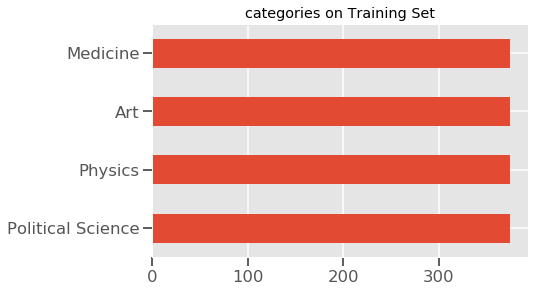

In [233]:
plotTrain = pd.DataFrame(data=y_train)
plotTrain["yTrain"] = pd.DataFrame(data=y_train)

plt.style.use("ggplot")
plotTrain.yTrain.value_counts().plot(kind="barh")
plt.title("categories on Training Set");

# So about even, but we should still probably make the split exactly even.

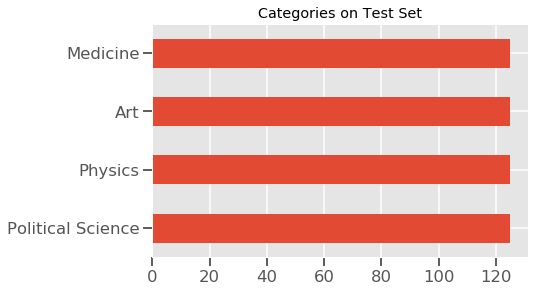

In [234]:
# Look at how even our test split is
plotTest = pd.DataFrame(data=y_test)
plotTest["yTest"] = pd.DataFrame(data=y_test)

plt.style.use("ggplot")
plotTest.yTest.value_counts().plot(kind="barh")
plt.title("Categories on Test Set");

# So about even, but we should still probably make the split exactly even.

# Naive bayes classification model

In [235]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

        
print("naive bayes Scoring")
Y_pred = nb.predict(X_test)
cr = classification_report(y_test, Y_pred)
print( cr)

# to save model
#with open(path + path2 + 'NB_model.pickle', 'rb') as f:  
#    NBmodel = pickle.load(f,encoding='latin1')

naive bayes Scoring
                   precision    recall  f1-score   support

              Art       0.91      0.86      0.89       125
         Medicine       0.94      0.96      0.95       125
          Physics       0.93      0.93      0.93       125
Political Science       0.94      0.97      0.95       125

        micro avg       0.93      0.93      0.93       500
        macro avg       0.93      0.93      0.93       500
     weighted avg       0.93      0.93      0.93       500



In [236]:
# Calculate accuracy.
print((metrics.accuracy_score(y_test, Y_pred)))

0.93


In [237]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.summer):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    
    return plt

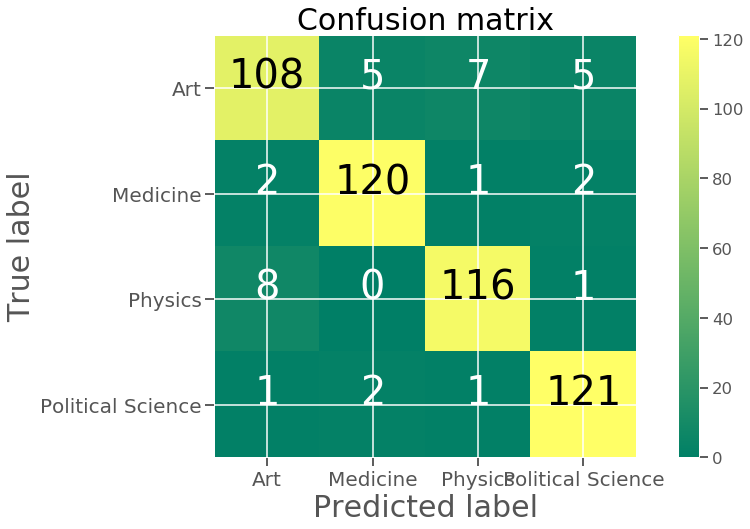

In [238]:
cm = confusion_matrix(y_test, Y_pred)
fig = plt.figure(figsize=(12, 7))
plot = plot_confusion_matrix(cm, classes=m.classes_, normalize=False)
#plt.savefig(path + path2 + "NB_confusion_matrix.svg")
plt.show()

# This is to show the relative fit of different methods, does not work for multi class...

def fit_roc(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    score = round(model.score(X_test,y_test),2)
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_proba[:,1])
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc,score
sns.set_context("talk")
fig0 = plt.figure(figsize=(15,8));
plt.plot([0, 1], [0, 1], lw=2, color = 'black' , linestyle='--')
    
fpr1, tpr1, roc_auc1, score1 = fit_roc(MultinomialNB(), X_train, X_test, y_train, y_test)
plt.plot(fpr1, tpr1, lw=2, color = 'brown', label='NB area=%0.2f,accuracy={}'.format(score1) % roc_auc1)
    
#fpr2, tpr2, roc_auc2, score2 = fit_roc(LogisticRegression(), X_train, X_test, y_train, y_test)
#plt.plot(fpr2, tpr2, lw=2, color = 'darkviolet', label='Log Reg area=%0.2f,accuracy={}'.format(score1) % roc_auc2)


# LDA on all papers
+ Do LDA on all abstracts with 4 topics to see if it can correctly classify our data
+ works well

In [239]:
def topic_mod_lda(data,topics=5,iters=10,ngram_min=1, ngram_max=3, max_df=0.6, max_feats=5000, random_state=42):
    
    """ use count vectorizer to turn words into numbers for each document(rows)
    then use Latent Dirichlet Allocation to get topics"""
    
    vectorizer = CountVectorizer(ngram_range=(ngram_min,ngram_max), 
                             stop_words='english', 
                             max_df = max_df, 
                             max_features=max_feats)
      
    #  `fit (train), then transform` to convert text to a bag of words

    vect_data = vectorizer.fit_transform(data)
    
    lda = LatentDirichletAllocation(n_components=topics,
                                    max_iter=iters,
                                    random_state=random_state,
                                    learning_method='online',
                                    n_jobs=-1)
    
    lda_data = lda.fit_transform(vect_data)
    
    # to display a list of topic words and their scores 
    def display_topics(model, feature_names, no_top_words):
        for ix, topic in enumerate(model.components_):
            print("Topic ", ix)
            print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    
    display_topics(lda, vectorizer.get_feature_names(),20)
    
    return vectorizer, vect_data, lda, lda_data

In [249]:
vect_mod, vect_data, lda_mod, lda_data = topic_mod_lda(papers["Abstract"],
                                                         topics=4,
                                                         iters=50,
                                                         ngram_min=1, 
                                                         ngram_max=2, 
                                                         max_df=0.5, 
                                                         max_feats=2000,
                                                         random_state=42)


Topic  0
international health la research countries en social el information world public global development science national se policy que education care
Topic  1
sports injuries injury athletes risk training exercise patients performance sport physical concussion related activity high studies study age years participation
Topic  2
space time field phase model using quantum optical results energy imaging dimensional theory state systems space time function based large spatial
Topic  3
color used paper art based different space data using new images image results use work radiation analysis design visual digital


In [250]:
topic_ind = np.argmax(lda_data, axis=1)
topic_ind.shape

#create labels for plotting with matplotlib 
labels_4_mpl = topic_ind

# put into dataframe for plotly
tsne_labels = pd.DataFrame(topic_ind)

# save to csv here if not assigning labels and leaving as numbers
#tsne_labels.to_csv('./data/topic_numbers.csv')

In [252]:
# 0= Political Science, International
# 1= Medicine, Sports
# 2= Physics, Space
# 3= Art, Color
tsne_labels[tsne_labels==0] = "Political Science"
tsne_labels[tsne_labels==1] = "Medicine"
tsne_labels[tsne_labels==2] = "Physics"
tsne_labels[tsne_labels==3] = "Art"

In [253]:
papers["Topic Classification"]= tsne_labels
papers.head()

,Source,Title,Abstract,Journal,Author,Date,Keyword,Keyword2,Keyword3,Keyword4,Keyword5,General,Citation,Field,Search Term,Sentiment,Topic Classification
0,https://www.semanticscholar.org/paper/Space-ch...,Space-charge limited photocurrent.,""":""In 1971 Goodman and Rose predicted the occu...",Physical review letters,Valentin D. Mihailetchi and Jurjen Wildeman an...,2005,Fullerenes,Immunostimulating conjugate (antigen),Switch Device Component,Semiconductors,light intensity,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Mihailetchi2005SpacechargeLP, title=...",Physics,Space,0.192755,Physics
1,https://www.semanticscholar.org/paper/Separabl...,Separable dual-space Gaussian pseudopotentials.,""":""We present pseudopotential coefficients for...","Physical review. B, Condensed matter",Goedecker and Teter and Hutter,1996,Dual,Normal Statistical Distribution,Multiplication,NaN,NaN,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Goedecker1996SeparableDG, title={Sep...",Physics,Space,0.128791,Physics
2,https://www.semanticscholar.org/paper/Canonica...,Canonical dynamics: Equilibrium phase-space di...,""":""Nose has modified Newtonian dynamics so as ...","Physical review. A, General physics",Hoover,1985,Normal Statistical Distribution,Friction,CNS disorder,Test scaling,NaN,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Hoover1985CanonicalDE, title={Canoni...",Physics,Space,-0.070000,Physics
3,https://www.semanticscholar.org/paper/Flat-spa...,Flat-space chiral gravity.,""":""We provide the first evidence for a hologra...",Physical review letters,Arjun Bagchi and St{\'e}phane Detournay and Da...,2012,Holographic principle,Quantum field theory,Calcifying Fibrous Pseudotumor,Hornbostelâ€“Sachs,Battery management system,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Bagchi2012FlatspaceCG, title={Flat-s...",Physics,Space,-0.089286,Physics
4,https://www.semanticscholar.org/paper/Polariza...,Polarization demultiplexing in Stokes space.,""":""A technique is demonstrated for polarizatio...",Optics express,Bogdan Szafraniec and Bernd Nebendahl and Todd...,2010,chaperone-mediated autophagy,algorithm,Fiber Optic Cables,NaN,NaN,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Szafraniec2010PolarizationDI, title=...",Physics,Space,0.095000,Physics


# use classifer NB model  on all data to get prediction 

In [255]:
pred_class = nb.predict(X)

papers["NB Classification"]= pred_class
print((metrics.accuracy_score(papers["Field"], papers["NB Classification"])))

0.971


In [254]:
# vs. accuracy for the LDA method
print((accuracy_score(papers["Field"], papers["Topic Classification"])))

0.8055


# tsne 

In [256]:
labels_t = pd.DataFrame(labels_4_mpl)
labels_t.rename(columns={0:'topic'},inplace=True)

In [257]:
# you can then do tsne with this to see if similar docs have been assigned similar topics. 
 
# a t-SNE model
# angle value close to 1 means sacrificing accuracy for speed
# pca initializtion usually leads to better results 
tsne_model = TSNE(n_components=3, verbose=1, random_state=44, angle=.50,
                  perplexity=18,early_exaggeration=1,learning_rate=30.0)#, init='pca'
 
# 20-D -> 3-D
tsne_lda = tsne_model.fit_transform(lda_data)
tsne_data = pd.DataFrame(tsne_lda,columns=['zero','one','two'])
 
ty = pd.merge(tsne_data,labels_t, left_index=True, right_index=True, how='outer')
ty.topic.astype(str,inplace=True)
ty.head()
 

[t-SNE] Computing 55 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.002526
[t-SNE] KL divergence after 250 iterations with early exaggeration: 0.761229
[t-SNE] KL divergence after 1000 iterations: 0.510428


,zero,one,two,topic
0,10.080636,-16.544899,9.299607,2
1,8.254885,-10.685078,-2.171875,2
2,3.473177,8.882366,18.358177,2
3,-0.408806,-11.742293,6.727388,2
4,-15.337961,-12.919457,3.663917,2


In [258]:
# plot interactive 3D
fig = px.scatter_3d(ty, x='zero', y='one', z='two',
              color='topic', title='25 topics', opacity=0.99)#  size_max=28,
fig.show()

# assign papers to each category pased on the NB classifier

In [259]:
art_papers= papers.where(papers["NB Classification"]=="Art")
art_papers= art_papers.dropna()
art_papers["Abstract"][0:5]

25     ":"truly remarkable. Our ability to see colors...
100    ":"The goal of our research is to enable artis...
131     of the 2D neural receptive fields found in th...
147    ":"Un etat de spin chiral est caracterise par ...
152    ":"We do colour image processing in an RGB-der...
Name: Abstract, dtype: object

In [260]:
medicine_papers= papers.where(papers["NB Classification"]=="Medicine")
medicine_papers= medicine_papers.dropna()
political_papers= papers.where(papers["NB Classification"]=="Political Science")
political_papers= political_papers.dropna()
physics_papers= papers.where(papers["NB Classification"]=="Physics")
physics_papers= physics_papers.dropna()

# LDA on policital Science class (based on NB)

In [262]:
del vect_mod, vect_data, lda_mod, lda_data 
vect_mod, vect_data, lda_mod, lda_data = topic_mod_lda(political_papers["Abstract"],
                                                         topics=15,
                                                         iters=50,
                                                         ngram_min=1, 
                                                         ngram_max=2, 
                                                         max_df=0.5, 
                                                         max_feats=2000,
                                                         random_state=42)

Topic  0
icc action study country countries groups leaders action icc different focus way living london crimes mental quantitative qualitative criminal refugees somali
Topic  1
english zika tramsen german countries facebook copenhagen iavi research populations denmark language twitter scholarly danish medical later 2013 capacity activities
Topic  2
selection sexual signalling sexual selection sports signalling sexual evolution solutions benefits costs impact major powerful research study application interactions misleading empirical natural
Topic  3
data industry countries cultural conflicts conventions financial workers research financial conflicts studies institutions idb academic differences role demographic important original industry sponsorship
Topic  4
shortage eeg guidelines epilepsy nurses governance feature problems scholars resource special feature published reducing special europe falsely used report document standards
Topic  5
health public public health acculturation outc

In [263]:
def post_lda_labels(class_df, lda_model, lda_df, vect_model, num_words):

    # assign each document to it's max topic
    topic_ind = np.argmax(lda_df, axis=1)
    topic_ind.shape

    #create labels for plotting with matplotlib 
    labels_mpl = topic_ind

    # put into dataframe 
    tsne_labels = pd.DataFrame(labels_mpl)
    
    # get the names of each feature
    key_words = vect_model.get_feature_names()

    
    for ix, topic in enumerate(lda_model.components_):

        tsne_labels[tsne_labels==ix] =str([key_words[i] for i in topic.argsort()[:-num_words - 1:-1]])

    class_df["LDA Keywords"]= tsne_labels.values
    return class_df
    

In [264]:
political_papers = post_lda_labels(political_papers, lda_mod, lda_data, vect_mod, 5)

# LDA on physics class based on the NB classification

In [265]:
del vect_mod, vect_data, lda_mod, lda_data 
vect_mod, vect_data, lda_mod, lda_data = topic_mod_lda(physics_papers["Abstract"],
                                                         topics=15,
                                                         iters=50,
                                                         ngram_min=1, 
                                                         ngram_max=2, 
                                                         max_df=0.5, 
                                                         max_feats=2000,
                                                         random_state=42)

Topic  0
ear processing impedance air emesis middle middle ear filters ear air air space angular orbital light grid studies fused momentum angular momentum states result
Topic  1
imaging kcd charge spatial field using sta method space charge snr detection transmit range rate density detector resolution signals encoding local
Topic  2
time imaging space time compressive phase surface instrument compressive imaging quantum dynamical orbit experiments illumination interreflection time compressive spacelab images algorithm range based
Topic  3
sonographic gravity molecules measurements subacromial space ground radiographic related subacromial polar morphology systems hze single examination ground state rovibrational state rovibrational ground gas
Topic  4
method optical flow optical flow image differential proposed real paper strategy scale analysis results demonstrated scheme means linear approach methods using
Topic  5
analysis verification lsc systems model properties cpn model lsc lang

In [266]:
physics_papers = post_lda_labels(physics_papers, lda_mod, lda_data, vect_mod, 5)

# LDA on art class based on the NB classification

In [267]:
del vect_mod, vect_data, lda_mod, lda_data 
vect_mod, vect_data, lda_mod, lda_data = topic_mod_lda(art_papers["Abstract"],
                                                         topics=15,
                                                         iters=50,
                                                         ngram_min=1, 
                                                         ngram_max=2, 
                                                         max_df=0.5, 
                                                         max_feats=2000,
                                                         random_state=42)

Topic  0
la en el se que los et des para del color les le las du blue una dans une imagenes
Topic  1
color samples fat levels light used cheese light levels red reflectance significant attributes change color names names observers vision different aesthetic significantly
Topic  2
f0 mandarin speakers languages english compared differ samples higher speech tone critical similar single means having determined word profile compare
Topic  3
lens preferred lenses viewing tinted tinted lenses paintings subjects photographs yellow purple nature clear tint preferred viewing nature photographs cosmesis lens tint wear clear lens
Topic  4
npr brushstrokes photo create technique source types source photo expression artworks tool way effective non elements allow makes difficult developing basic
Topic  5
color bowery vision work test patients information spherical analysis images image axis postmodern postmodernism chromoendoscopy results color vision rosler adaptation turtle
Topic  6
titanium porce

In [268]:
art_papers = post_lda_labels(art_papers, lda_mod, lda_data, vect_mod, 5)

# LDA on medicine class based on the NB classification

In [269]:
del vect_mod, vect_data, lda_mod, lda_data 
vect_mod, vect_data, lda_mod, lda_data = topic_mod_lda(medicine_papers["Abstract"],
                                                         topics=15,
                                                         iters=50,
                                                         ngram_min=1, 
                                                         ngram_max=2, 
                                                         max_df=0.5, 
                                                         max_feats=2000,
                                                         random_state=42)

Topic  0
exercise athletes patients physical performance disease use effects athletic risk sport death high activities pain drugs athlete artery doping health
Topic  1
injury risk factors studies research study participation risk factors injuries sports injury time measures sports participation ci analysis used data 95 associated athletes
Topic  2
injuries injury athletes sport common sports injuries risk fractures overuse years eye players patients age study knee football males females high
Topic  3
concussion medicine injury sports medicine management related concussions symptoms athletes use athlete brain sports related training provide clinical based evaluation sport patient
Topic  4
girls boys iron school children srrcs iron deficiency deficiency youth school sports athletes years deaf red cell 20 concussions 15 number high
Topic  5
performance changes bodyweight reliability diet increase muscle activity intake individuals exercise training effects fatigue athletes term short term

In [270]:
medicine_papers = post_lda_labels(medicine_papers, lda_mod, lda_data, vect_mod, 5)

# concat all papers and keywords back into one df

In [271]:
all_papers = pd.concat([political_papers, physics_papers, art_papers, medicine_papers],sort=False)

In [272]:
all_papers["author_keywords"] = all_papers["Keyword"] + ', ' + all_papers["Keyword2"] + ', ' + all_papers["Keyword3"]+ ', ' + all_papers["Keyword4"]+ ', ' +all_papers["Keyword5"]
all_papers.head()

,Source,Title,Abstract,Journal,Author,Date,Keyword,Keyword2,Keyword3,Keyword4,Keyword5,General,Citation,Field,Search Term,Sentiment,Topic Classification,NB Classification,LDA Keywords,author_keywords
504,https://www.semanticscholar.org/paper/Internat...,International spaces promote peace,""":""Lessons are still being learnt from the Ant...",Nature,Paul Arthur Berkman,2009,jurisdiction,Probability,Conflict (Psychology),Alveolar rhabdomyosarcoma,International Cooperation,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Berkman2009InternationalSP, title={I...",Political Science,International,-0.750000,Political Science,Political Science,"['tuberculosis', 'mortality', 'health', 'disea...","jurisdiction, Probability, Conflict (Psycholog..."
507,https://www.semanticscholar.org/paper/DB-289-I...,DB-289 Immtech International.,""":""DB-289, an oral diamidoxime prodrug of DB-7...",IDrugs : the investigational drugs journal,Clive Leonard Yeates,2003,Genus Pneumocystis,DB 289,Pneumocystis jiroveci pneumonia,Malaria,Trypanosomiasis,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Yeates2003DB289II, title={DB-289 Imm...",Political Science,International,-0.162500,Political Science,Political Science,"['tuberculosis', 'mortality', 'health', 'disea...","Genus Pneumocystis, DB 289, Pneumocystis jirov..."
508,https://www.semanticscholar.org/paper/Extrater...,Extraterrestrial intelligence: an internationa...,""":""The human species is now able to communicat...",Science,Carl Sagan,1982,Civilization,paragraphs,subsidiary,Search Engine,radiofrequency,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Sagan1982ExtraterrestrialIA, title={...",Political Science,International,0.072634,Political Science,Political Science,"['population', 'information', 'world', 'china'...","Civilization, paragraphs, subsidiary, Search E..."
515,https://www.semanticscholar.org/paper/Understa...,Understanding international crime trends: the ...,""":""This study shows a very strong association ...",Environmental research,Rick Nevin,2007,Lead Poisoning,Crime Act,Cognition Disorders,Attention deficit hyperactivity disorder,Gasoline,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Nevin2007UnderstandingIC, title={Und...",Political Science,International,0.015361,Medicine,Political Science,"['social', 'stereotype', 'media', 'social medi...","Lead Poisoning, Crime Act, Cognition Disorders..."
519,https://www.semanticscholar.org/paper/Informed...,Informed consent for research: international p...,""":""Problems in obtaining and documenting infor...",Journal of the American Medical Women's Associ...,Ruth Macklin,2000,Consent Forms,Confusion,Documented,standards characteristics,Reproductive Health,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Macklin2000InformedCF, title={Inform...",Political Science,International,0.050714,Political Science,Political Science,"['health', 'dimensions', 'organizational', 'di...","Consent Forms, Confusion, Documented, standard..."
